<a href="https://colab.research.google.com/github/vivekp12/dst-group-project-2/blob/main/VivekP/03-DataLoading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis

In this document, we perform exploratory data analysis on the [brain tumour MRI dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data) [1]. The document is structured as follows:

**Table of Contents**:
1. [Requirements](#requirements)

2.


# Requirements

We first load the requirements.

In [16]:
pip install kagglehub

We next load the dataset. This dataset is downloaded from Kaggle.

In [17]:
# Instructions taken from https://www.kaggle.com/docs/api#authentication

import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1


The following Kaggle [discussion](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896) suggests the presence of duplicate images in the dataset. We use their provided code [2] to check for duplicates.

In [18]:
import os  # Import os module for file operations
import hashlib

# Define your project directory and labels based on your dataset structure
PROJECT_DIR = path
LABELS = ['pituitary','notumor', 'meningioma', 'glioma'] # Adjust these labels based on your dataset's folder names

def compute_hash(file):
    hasher = hashlib.md5()
    with open(file, 'rb') as f:
        buf = f.read()
        hasher.update(buf)
    return hasher.hexdigest()


def list_files(hash_dict):
    for data_type in ['Training', 'Testing']:
        for label in LABELS:
            folder_path = os.path.join(PROJECT_DIR, 'data', 'raw', data_type, label)
            for root, dirs, files in os.walk(folder_path):
                for file in files:
                    if file.endswith(".jpg"):
                        file_path = os.path.join(root, file)
                        file_hash = compute_hash(file_path)
                        if file_hash in hash_dict:
                            hash_dict[file_hash].append(file_path)
                        else:
                            hash_dict[file_hash] = [file_path]


def remove_duplicates(hash_dict):
    duplicate_count = 0
    for hash_value, file_paths in hash_dict.items():
        if len(file_paths) > 1:
            for file_path in file_paths[1:]:
                print(f"Removing duplicate (hash : {hash_value}) : {file_path}")
                os.remove(file_path)
                duplicate_count += 1
    print(f"Number of duplicates : {duplicate_count}")


if __name__ == '__main__':
    hash_dict = {}
    list_files(hash_dict)
    remove_duplicates(hash_dict)

Number of duplicates : 0


The output of the code suggests that there are in fact no duplicates. We have double-checked this by each running this code and confirmed that there are no duplicates. We proceed, checking the class distributions in the training and test data.

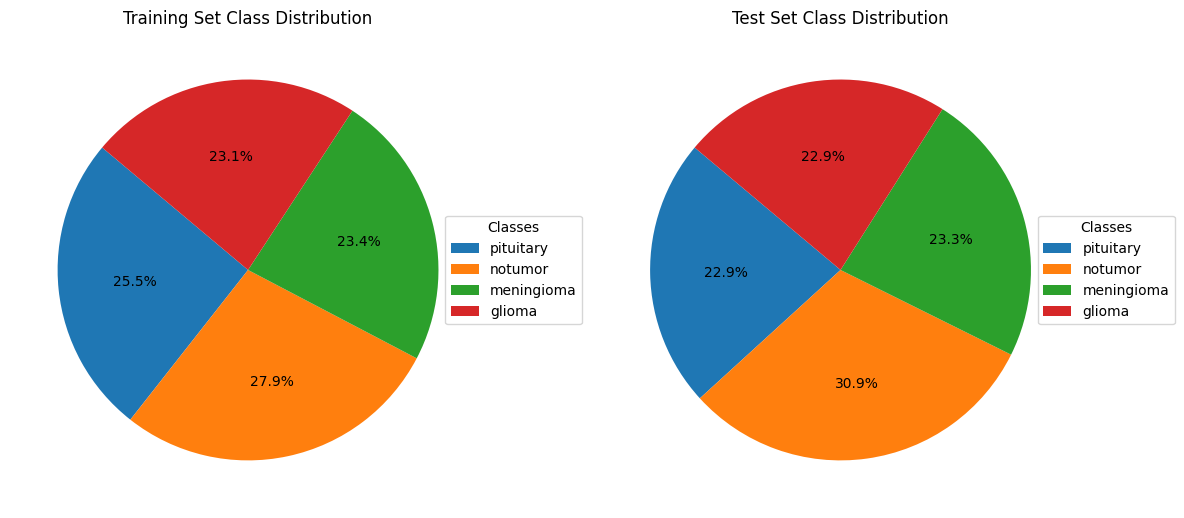

In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from pathlib import Path

base_path = Path(path)
train_dir = base_path / "Training"
test_dir = base_path / "Testing"
labels = ['pituitary', 'notumor', 'meningioma', 'glioma']

def get_class_distribution(directory):
    class_counts = {}
    for label in labels:
        class_path = directory / label
        class_counts[label] = len(list(class_path.glob('*.jpg')))  # assuming images are in .jpg format
    return class_counts

train_class_counts = get_class_distribution(train_dir)
test_class_counts = get_class_distribution(test_dir)

# Training Set Pie Chart with Legend
plt.figure(figsize=(12, 6))

# Training set distribution
plt.subplot(1, 2, 1)
plt.pie(train_class_counts.values(), autopct='%1.1f%%', startangle=140)
plt.title("Training Set Class Distribution")
plt.legend(train_class_counts.keys(), title="Classes", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

# Test set distribution
plt.subplot(1, 2, 2)
plt.pie(test_class_counts.values(), autopct='%1.1f%%', startangle=140)
plt.title("Test Set Class Distribution")
plt.legend(test_class_counts.keys(), title="Classes", loc="center left", bbox_to_anchor=(0.9, 0, 0.5, 1))

plt.tight_layout()
plt.show()

We can see that there is no problem of imbalance, as the classes are approximately evenly split in the training and test data. Next, we look at the image dimensions. This will give us an idea of how much information is stored in each image, and give us a sense of the "dimensionality" of the dataset.

We next view the actual images to understand what it looks like.

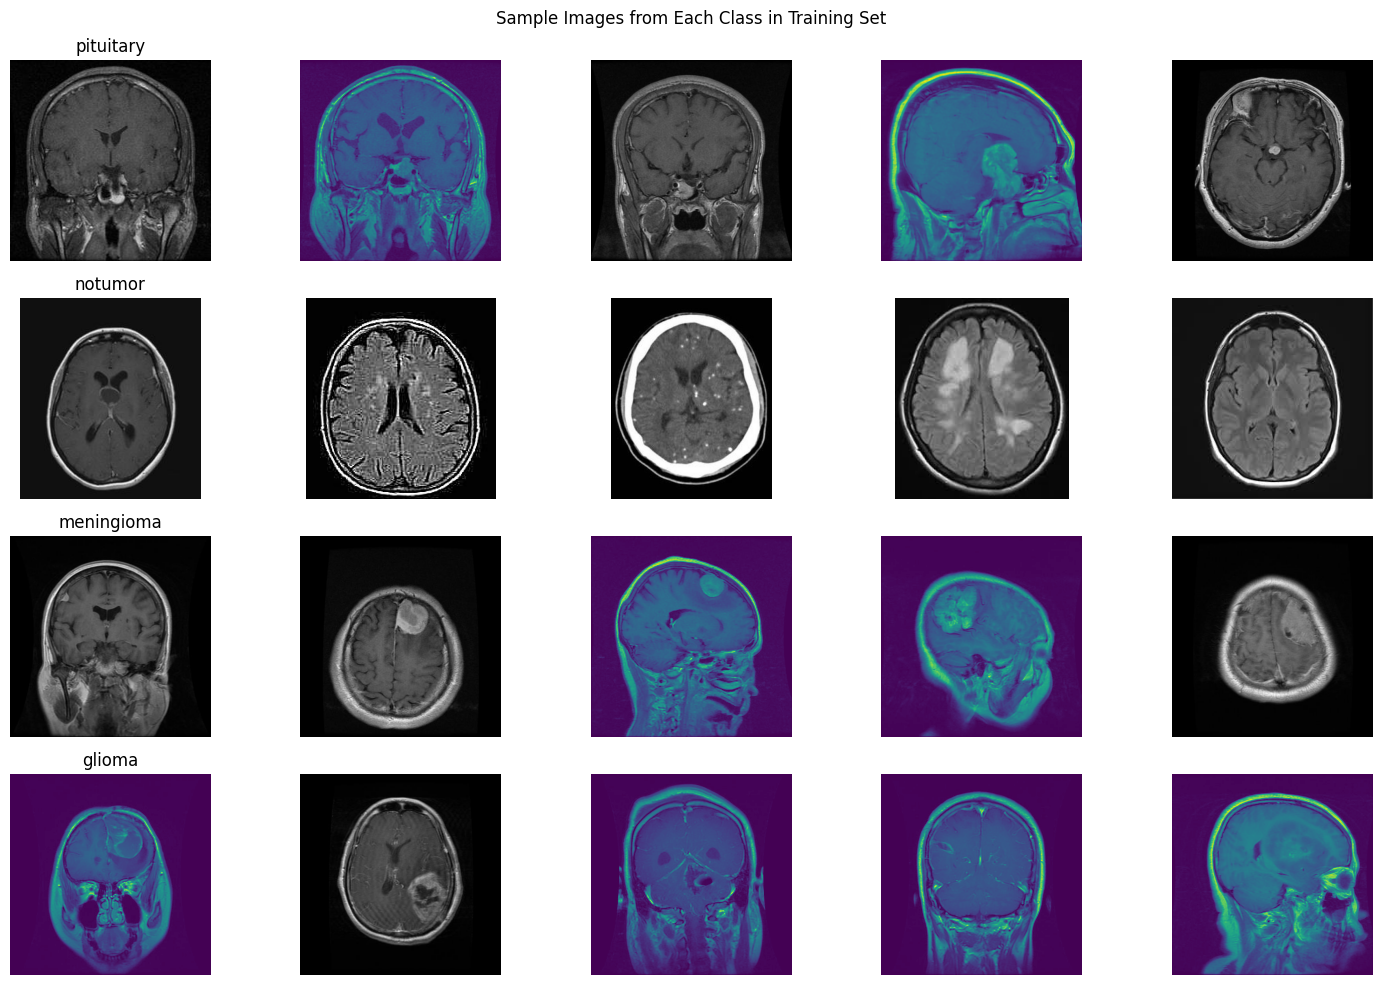

In [20]:
fig, axes = plt.subplots(len(labels), 5, figsize=(15, 10))
for idx, label in enumerate(labels):
    class_path = train_dir / label
    images = list(class_path.glob('*.jpg'))[:5]  # Get the first 5 images from each class
    for j, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[idx, j].imshow(img)
        axes[idx, j].axis('off')
        if j == 0:
            axes[idx, j].set_title(label)
plt.suptitle('Sample Images from Each Class in Training Set')
plt.tight_layout()
plt.show()


We can see that this dataset seems to have some images being black and white and others having colour. We can also see that there are different angles at which the MRI scans are taken, providing an insight into the information a model could use to make predictions. We can see some blobs, which are the tumours. This is clearest in the fourth image in the fourth row, with a clear white blob. To the untrained eye, it is however difficult to tell the difference between the different tumour types (meningioma,  glioma, pituitary).

## A Discussion on Image Sizes
Looking at the fourth column, we can see that the images are of different sizes. This is a problem for the model as the input layer for a neural network will only allow inputs of a fixed size. While it may be possible to crop dynamically, this is an inefficient use of memory. To get around this issue, pre-processing is needed. Common methods include resizing (changing the dimensions of the image) and padding (adding a black space to uniformise the sizes). In this caseThere are several advantages to doing this, rather than a procedure such as padding (adding in black space instead of resizing) [3]. We explain some of the advantages below:
1. Square images facilitate the use of pre-trained models. Some state-of-the-art models, such as VGGNet or ResNet, have been trained on square images. By resizing our images to a square shape, we can leverage these pre-trained models more effectively, as the input dimensions of our images match those of the pre-trained models. This enables transfer learning, where the pre-trained models' learned features can be utilized to improve the accuracy and efficiency of our own CNN models. The so-called "tensors" in a batch, used in training, are expected to be the same size [4].

2. Resizing images to a square shape helps to maintain consistency in the input dimensions across the dataset. The input layer will require inputs of a fixed size [5]. While dynamic cropping is possible, it is an inefficient use of memory and is unadvisable as we have a limited time and computational budget. By resizing all images to a square shape, we ensure that they have the same width and height, which simplifies the data handling and processing steps.

3. If a large part of the image is padded, the CNN will have to learn that the black part of the image is not relevant and does not help distinguishing between the classes, as there is no correlation between the pixels in the black part and belonging to a given class. This is not hard coded so the CNN will have to learn it, and this might probably take some epochs. This is feasible if we have time and computational power, but otherwise, resizing would be more feasible (explanation adapted from [3]).

To perform the resizing, we run the following pre-processing code provided by the dataset creator. We annotate their code with additional comments and provide an explanation of what it does after the next code block.

In [21]:
### Code provided by dataset creator, taken from https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py
### Additional comments were added (indicated)

import numpy as np               # Import NumPy for numerical operations
from tqdm import tqdm            # Import tqdm for progress bars (not used here, could be useful for loops)
import cv2                       # Import OpenCV for image processing functions
import os                        # Import os for file and directory operations
import imutils                   # Import imutils, a utility library for OpenCV operations

def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    # Convert the image to grayscale (required for thresholding)  ### Additional comment
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise and detail in the image  ### Additional comment
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Threshold the image to create a binary version, where regions of interest are white  ### Additional comment
    # Then perform erosions and dilations to remove small noise in the thresholded image  ### Additional comment
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours (outlines of shapes) in the thresholded image  ### Additional comment
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)  # Extract contours with imutils (for compatibility)  ### Additional comment

    # Select the largest contour  ### Additional comment
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points (left, right, top, bottom) of the largest contour  ### Additional comment
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Define the margin around the crop (0 pixels here, but adjustable if needed)  ### Additional comment
    ADD_PIXELS = 0

    # Crop the image to the bounding box defined by extreme points, then return the cropped image  ### Additional comment
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

    return new_img

# Main processing block, executes when the script is run directly  ### Additional comment
if __name__ == "__main__":
    # Define directories for training and testing images  ### Additional comment
    training = train_dir
    testing = test_dir

    # List the folders (classes) inside training and testing directories  ### Additional comment
    training_dir = os.listdir(training)
    testing_dir = os.listdir(testing)

    # Define the target image size for resizing  ### Additional comment
    IMG_SIZE = 256

    # Loop over each class directory in the training data  ### Additional comment
    for dir in training_dir:
        # Define path to save cleaned images for the current class in training set  ### Additional comment
        save_path = 'cleaned/Training/'+ dir
        path = os.path.join(training, dir)  # Path to the class folder in the training directory  ### Additional comment
        image_dir = os.listdir(path)        # List images in the current class directory  ### Additional comment

        # Process each image within the class directory  ### Additional comment
        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))  # Load the image
            new_img = crop_img(image)                    # Crop the image to focus on main region
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))  # Resize to standard dimensions

            # Create save directory if it doesn't exist  ### Additional comment
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # Save the processed image in the cleaned directory  ### Additional comment
            cv2.imwrite(save_path+'/'+img, new_img)

    # Repeat the same process for the testing data  ### Additional comment
    for dir in testing_dir:
        save_path = 'cleaned/Testing/'+ dir       # Define save path for testing images in cleaned folder
        path = os.path.join(testing, dir)         # Path to the class folder in the testing directory
        image_dir = os.listdir(path)              # List images in the current testing class directory

        for img in image_dir:
            image = cv2.imread(os.path.join(path, img))  # Load the image
            new_img = crop_img(image)                    # Crop to main region
            new_img = cv2.resize(new_img, (IMG_SIZE, IMG_SIZE))  # Resize to 256x256 pixels

            # Create save directory if it doesn't exist
            if not os.path.exists(save_path):
                os.makedirs(save_path)

            # Save processed testing image
            cv2.imwrite(save_path+'/'+img, new_img)

This code standardizes all images to a fixed size. The `crop_img` function takes an image and applies the following preprocessing steps:

- Grayscale Conversion and Blurring: The image is converted to grayscale and blurred to reduce noise, making it easier to isolate the main region.
- Thresholding and Noise Removal: The blurred image is thresholded to create a binary (black-and-white) version. Then, small noise regions are removed with **erosion** and **dilation** operations (explained below).
- Cropping: The function crops the image to a 256 x 256 square.

Erosion and dilation are used to modify the shapes and sizes of objects in a black and white (also called binary) image. These operations are particularly helpful for tasks like joining disparate elements in an image and finding of intensity bumps or holes in an image [6]. We explain in more detail below:

1. Erosion removes pixels from the edges of objects in a binary image, effectively shrinking or "eroding" the white regions. This operation is helpful for removing small, isolated white noise in the background. Erosion is commonly used to remove small noise or separate objects that are close together.
2. Dilation does the opposite of erosion [7]; it adds pixels to the boundaries of objects, making white regions expand. This operation can "fill in" small holes or gaps within objects.

These image processing techniques can be expressed using mathematical formulae but we refer the reader [6] for details, in the interest of brevity.

We next check if this process worked well, by checking the image dimensions.

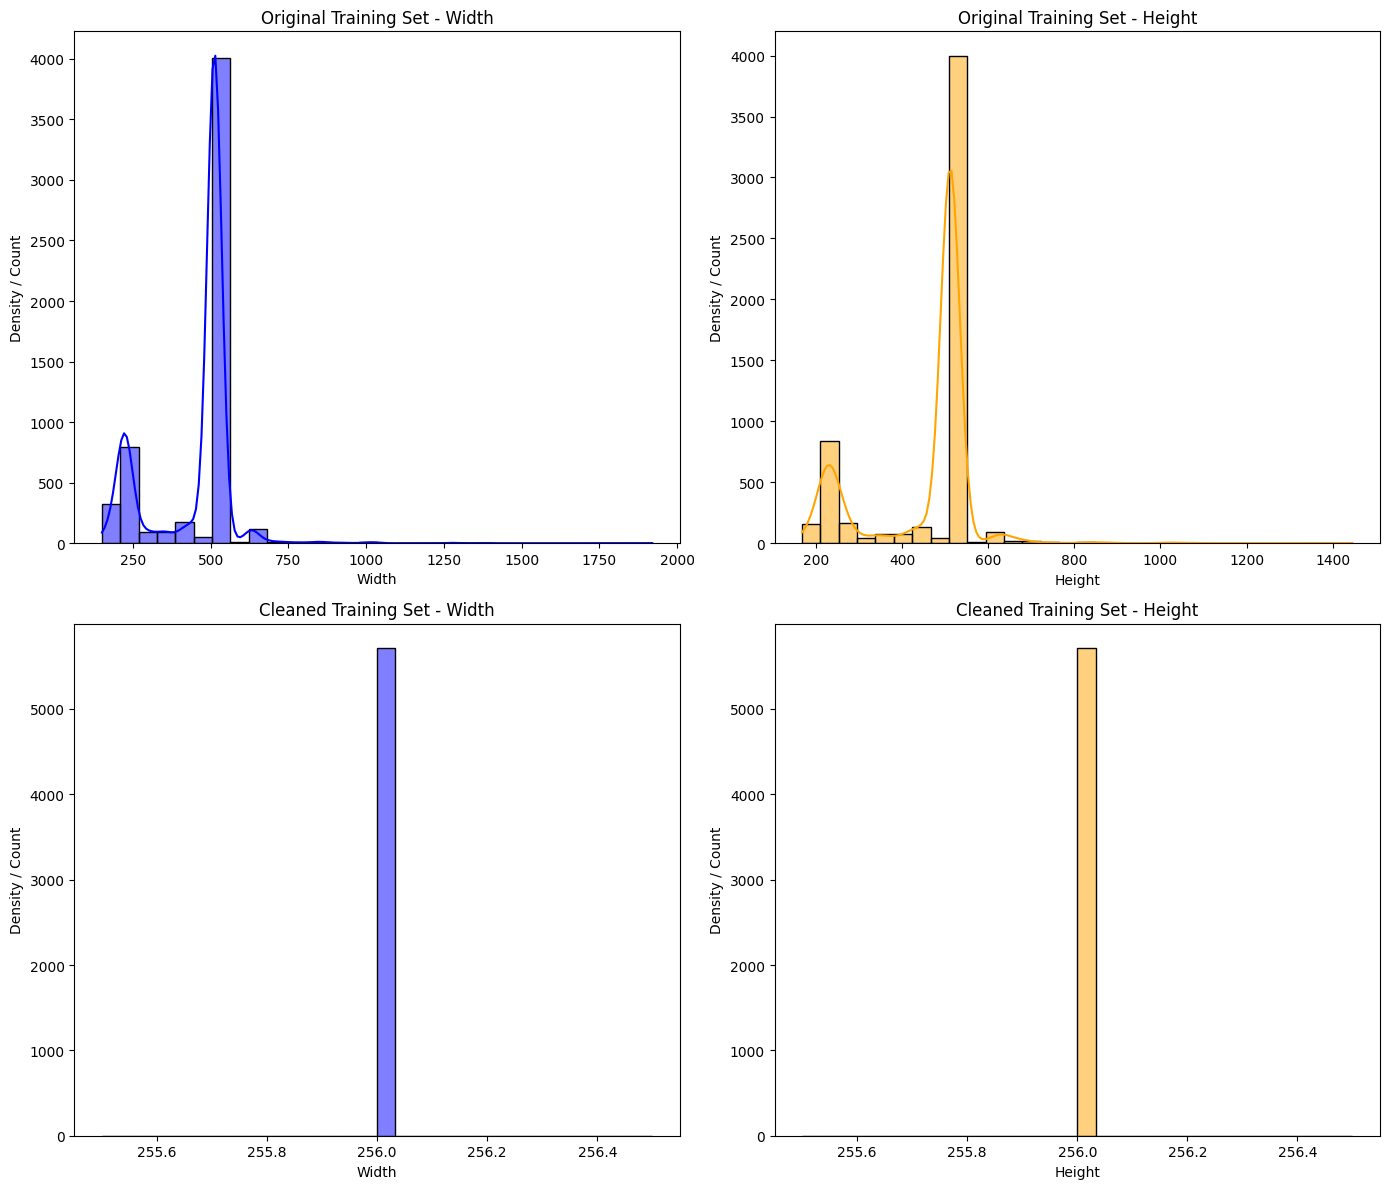

In [26]:
import os
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image

def get_image_dimensions(directory, labels):
    dimensions = []
    for label in labels:
        class_path = Path(directory) / label
        for image_file in class_path.glob('*.jpg'):
            with Image.open(image_file) as img:
                dimensions.append(img.size)  # (width, height)
    return dimensions

# Assuming 'labels' is defined and common between both datasets
# Dimensions for original training set
train_dimensions = get_image_dimensions(train_dir, labels)
df_train_dimensions = pd.DataFrame(train_dimensions, columns=['Width', 'Height'])

# Dimensions for cleaned training set
cleaned_dimensions = get_image_dimensions(Path("cleaned/Training"), labels)
df_cleaned_dimensions = pd.DataFrame(cleaned_dimensions, columns=['Width', 'Height'])

# Plot side-by-side KDE and Histogram combined plots for both datasets
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Original Training Set - Combined KDE and Histogram for Width
sns.histplot(df_train_dimensions["Width"], color="blue", bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original Training Set - Width')
axes[0, 0].set_xlabel('Width')
axes[0, 0].set_ylabel('Density / Count')

# Original Training Set - Combined KDE and Histogram for Height
sns.histplot(df_train_dimensions["Height"], color="orange", bins=30, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Original Training Set - Height')
axes[0, 1].set_xlabel('Height')
axes[0, 1].set_ylabel('Density / Count')

# Cleaned Training Set - Combined KDE and Histogram for Width
sns.histplot(df_cleaned_dimensions["Width"], color="blue", bins=30, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Cleaned Training Set - Width')
axes[1, 0].set_xlabel('Width')
axes[1, 0].set_ylabel('Density / Count')
# Optional x-axis range check
if not df_cleaned_dimensions["Width"].between(250, 260).any():
    axes[1, 0].set_xlim(250, 260)

# Cleaned Training Set - Combined KDE and Histogram for Height
sns.histplot(df_cleaned_dimensions["Height"], color="orange", bins=30, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Cleaned Training Set - Height')
axes[1, 1].set_xlabel('Height')
axes[1, 1].set_ylabel('Density / Count')
# Optional x-axis range check
if not df_cleaned_dimensions["Height"].between(250, 260).any():
    axes[1, 1].set_xlim(250, 260)

plt.tight_layout()
plt.show()


We can clearly see that our pre-processing was successful. We have created images of size 256 x 256, which is much more uniform than the original pictures, which had a variety widths and heights. We view the images again, to compare the effect of the image pre-processing.

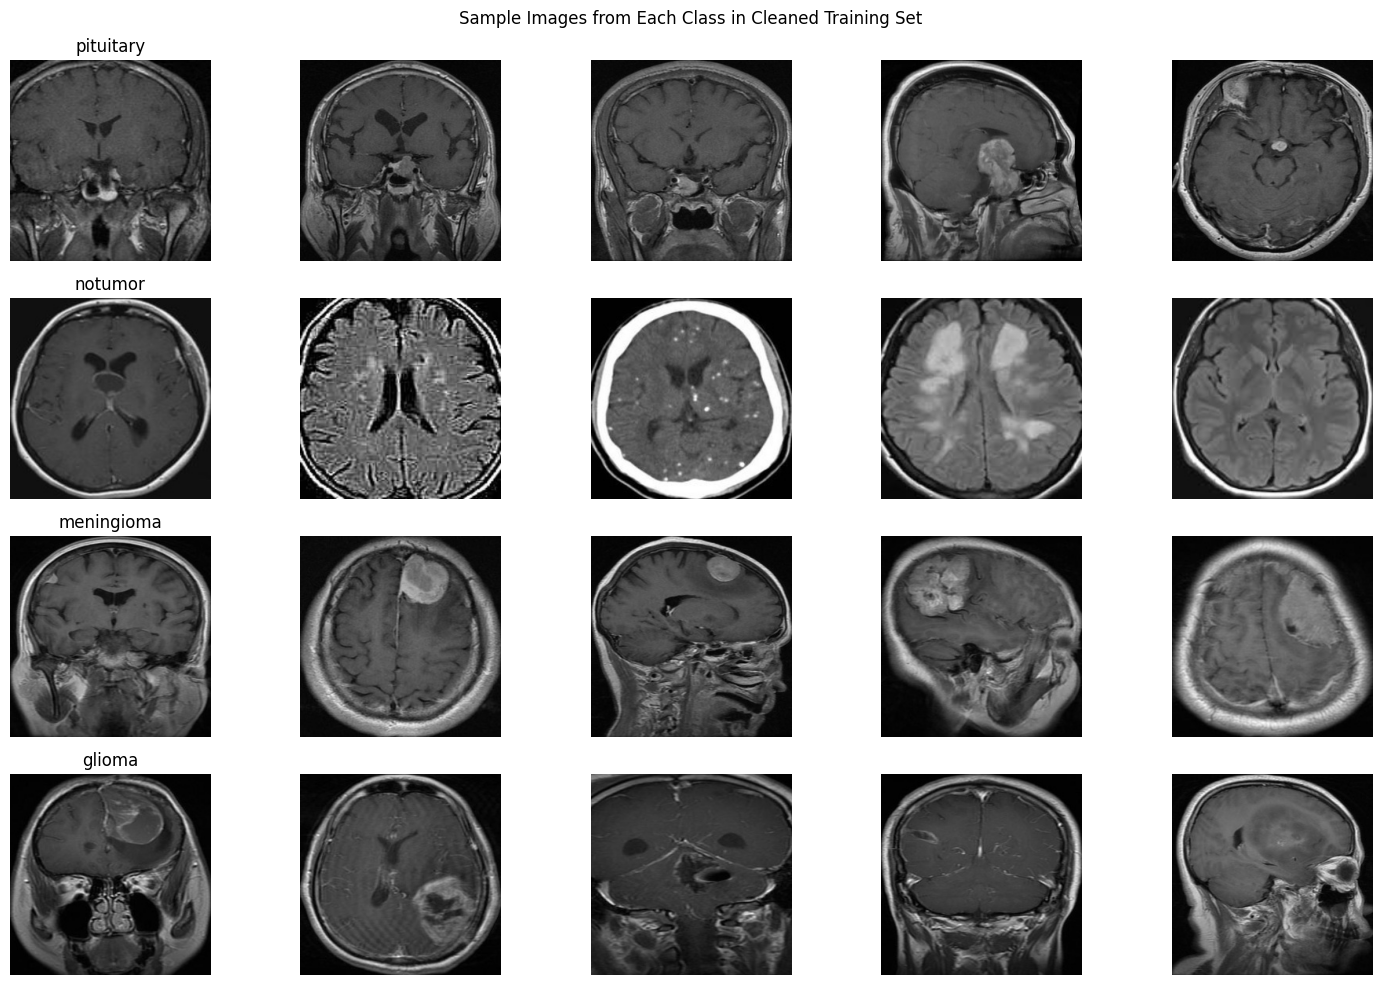

In [27]:
# Define the path to the cleaned training set
cleaned_train_dir = Path("cleaned/Training")

# Plot sample images from each class in cleaned training set
fig, axes = plt.subplots(len(labels), 5, figsize=(15, 10))
for idx, label in enumerate(labels):
    class_path = cleaned_train_dir / label
    images = list(class_path.glob('*.jpg'))[:5]  # Get the first 5 images from each class
    for j, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[idx, j].imshow(img)
        axes[idx, j].axis('off')
        if j == 0:
            axes[idx, j].set_title(label)

plt.suptitle('Sample Images from Each Class in Cleaned Training Set')
plt.tight_layout()
plt.show()

We can see that there are no more colours and the images are now a consistent size. We can see that perhaps this has cut off some of the features of the image. This is clearly seen in the fifth row (glioma) and the third column.

More to be done...

# References

[1] Brain tumour MRI dataset: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data

[2] Kaggle discussion on finding duplicates: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/discussion/482896

[3] Padding vs Resizing: https://stackoverflow.com/questions/47697622/cnn-image-resizing-vs-padding-keeping-aspect-ratio-or-not/49882055#49882055

[4] Resizing: https://datascience.stackexchange.com/questions/40462/how-to-prepare-the-varied-size-input-in-cnn-prediction

[5] Resizing: https://www.reddit.com/r/computervision/comments/1dda0eq/why_is_the_importance_of_resizing_the_images_why/

[6] OpenCV documentation to understand erosion and dilation: https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html

[7] Medium article on erosion and dilation: https://medium.com/@sasasulakshi/opencv-morphological-dilation-and-erosion-fab65c29efb3